In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import math
import time
import collections

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog
from scipy.ndimage.measurements import label
from mpl_toolkits.mplot3d import Axes3D

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

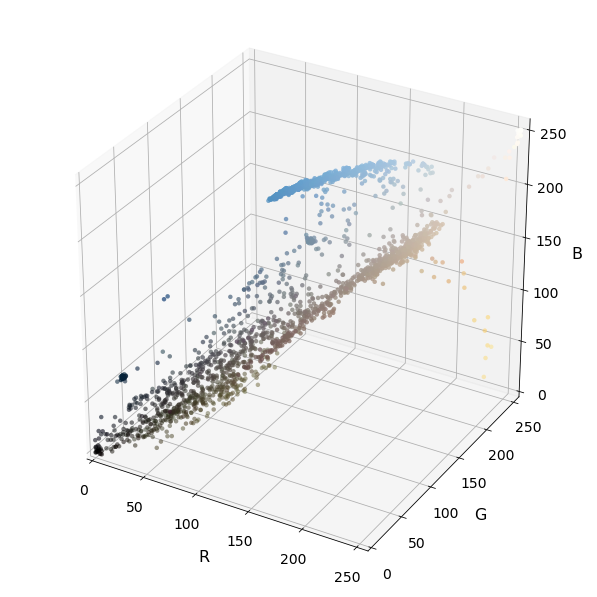

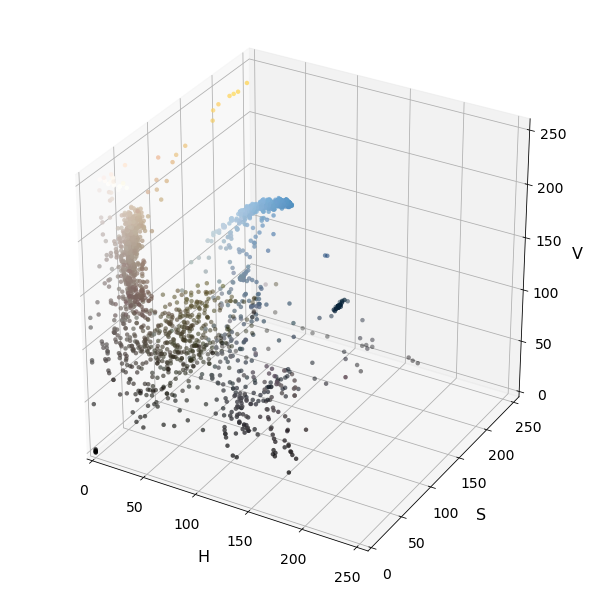

In [4]:
def plot_images(imgs, titles=None):
    """
    plot images of list in two columns
    """
    j_plots = 2
    i_plots = math.ceil(len(imgs)/j_plots)

    fig, axes = plt.subplots(i_plots, j_plots, figsize=(15, 5*i_plots))
    plt.tight_layout(pad=1, w_pad=1, h_pad=2.0)
    axes = axes.reshape(-1, 2)     
    
    i = 0
    for img in imgs:
        if len(img.shape) == 3:
            axes[i//j_plots, i%j_plots].imshow(img)
            pass
        else:
            axes[i//j_plots, i%j_plots].imshow(img, cmap='gray')
            
        if titles is not None:
            axes[i//j_plots, i%j_plots].set_title(titles[i])
        i += 1
    
    return

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread('test_images/test1.jpg')

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

## 1. Preparing Dataset

In [5]:
images = glob.glob('./*vehicles/*/*.png')
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

print(notcars[:3])
print(cars[:3])

['./non-vehicles/Extras/extra1.png', './non-vehicles/Extras/extra10.png', './non-vehicles/Extras/extra100.png']
['./vehicles/GTI_Far/image0000.png', './vehicles/GTI_Far/image0001.png', './vehicles/GTI_Far/image0002.png']


a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


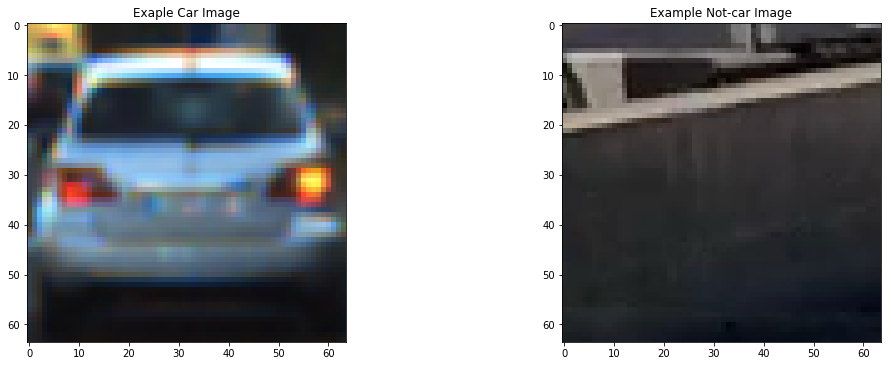

In [7]:
# return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for test choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = np.uint8(plt.imread(cars[car_ind]) * 255)
notcar_image = np.uint8(plt.imread(notcars[notcar_ind]) * 255)

# Plot the examples
plot_images([car_image, notcar_image], ['Exaple Car Image', 'Example Not-car Image'])


## 2. Extracting Features

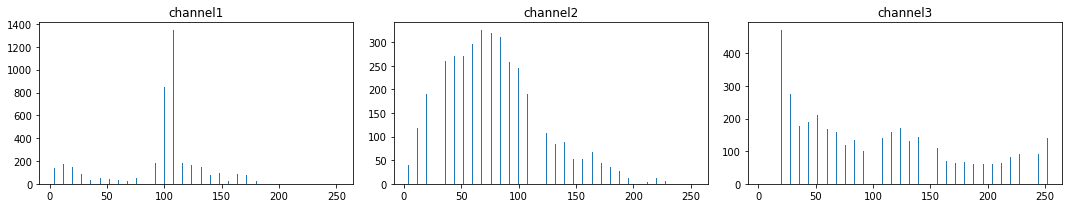

In [8]:

# compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def convert_color(img, cspace):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)
        
    return feature_image

# compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), visualize=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    if visualize:
        # Generating bin centers
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:] + bin_edges[0:-1])/2
        fig, axes = plt.subplots(1, 3, figsize=(15,3))
        axes[0].bar(bin_centers, channel1_hist[0])
        axes[0].set_title('channel1')
        axes[1].bar(bin_centers, channel2_hist[0])
        axes[1].set_title('channel2')
        axes[2].bar(bin_centers, channel3_hist[0])
        axes[2].set_title('channel3')
        fig.tight_layout()
        
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

cvt_image = convert_color(car_image, 'HSV')
_ = color_hist(cvt_image, nbins=32, bins_range=(0, 256), visualize=True)

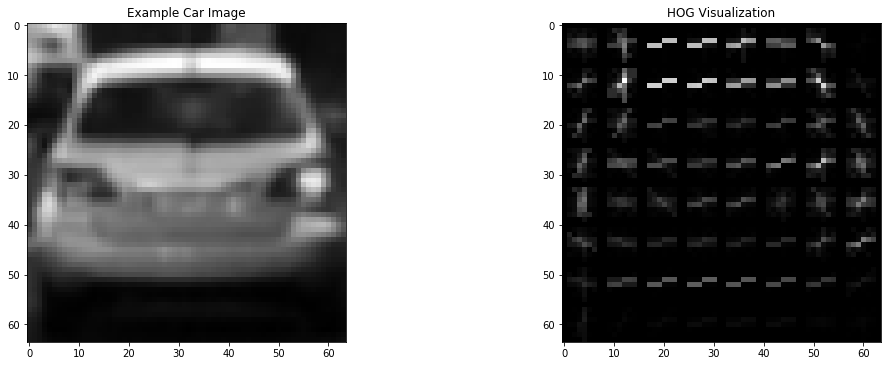

In [161]:
# return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    


gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 15
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
plot_images([gray, hog_image], ['Example Car Image', 'HOG Visualization'])


In [14]:

            
# extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_size=(32, 32),
                        hist_bins=64, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, cspace)

        # Apply bin_spatial() to get spatial color features
        if (spatial_size[0] != 0):
            spatial_features = bin_spatial(feature_image, size=spatial_size)
        else:
            spatial_features = np.array([]).reshape(-1)
        
        # Apply color_hist() also with a color space option now
        if (hist_bins != 0):
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        else:
            hist_features = np.array([]).reshape(-1)
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

spatial=0
histbin=0
colorspace = 'YUV'
hog_channel = 'ALL'
test_features = extract_features(cars[:2], cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))


## 3. Training Classifier

In [153]:

### Tweak these parameters and see how the results change.
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial = 0 #32
histbin = 16 #64 

orient = 15
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


t = time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to extract features...')


print(np.array(car_features).shape, len(notcar_features))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)     
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)




print('Using:', colorspace, 'colorspace', spatial, 'binning', histbin, 'histogram bins')
print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block', hog_channel, 'hog_channel')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

69.4 Seconds to extract features...
(8792, 8868) 8968
Using: YUV colorspace 0 binning 16 histogram bins
Using: 15 orientations 8 pixels per cell and 2 cells per block ALL hog_channel
Feature vector length: 8868
36.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9856
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  0.  1.  0.]
0.00197 Seconds to predict 10 labels with SVC


## 4. Detecting Cars

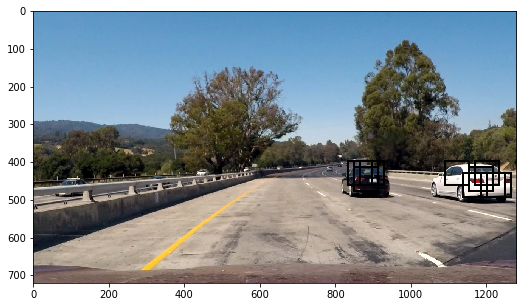

In [265]:

# extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              cspace='HSV', orient=9, pix_per_cell=8, cell_per_block=2, 
              hog_channel=0, spatial_size=(32, 32), hist_bins=64):  

    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace=cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, 
                                     (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if (hog_channel == 'ALL'):
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog = get_hog_features(ctrans_tosearch[:,:,hog_channel], 
                               orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    bbox_list = []
    draw_img = np.copy(img)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if (hog_channel == 'ALL'):
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, 
                                 xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, 
                                 xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, 
                                 xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog[ypos:ypos+nblocks_per_window, 
                                 xpos:xpos+nblocks_per_window].ravel()
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if (spatial_size[0] != 0):
                spatial_features = bin_spatial(subimg, size=spatial_size)
            else:
                spatial_features = np.array([]).reshape(-1)
                
            if (hist_bins != 0):
                hist_features = color_hist(subimg, nbins=hist_bins)
            else:
                hist_features = np.array([]).reshape(-1)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(
            #    np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),
                        (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(bbox)
                cv2.rectangle(draw_img,
                              (bbox[0][0], bbox[0][1]),
                              (bbox[1][0], bbox[1][1]),(0,0,255),3) 
                
    return bbox_list, draw_img
    
ystart = 380
ystop = 550
scale = 1.0


image = plt.imread('test_images/test1.jpg')

bbox_list, out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                    colorspace, orient, 
                    pix_per_cell, cell_per_block, hog_channel,
                    spatial_size=(spatial, spatial), hist_bins=histbin)
plt.figure(figsize=(15,5))
plt.imshow(out_img)

## 5. Thresholding Detection

(720, 1280) 2


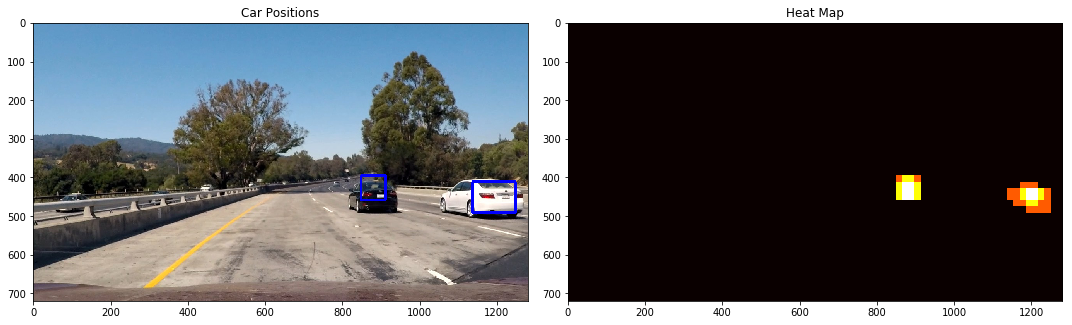

In [266]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(labels, img=None):
    # Iterate through all detected cars
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)

        if img != None:
            # Draw the box on the image
            #if car_number < 2:
            #    cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
            #elif car_number < 3:
            #    cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
            #else:
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    if img != None:
        return bbox_list, img
    else:
        return bbox_list


def threshold_on_heat(img, heats, threshold, bbox_list, visualize=False):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    #heat = apply_threshold(heat, threshold)
    #heatmap = np.clip(heat, 0, 255)
    #labels = label(heatmap)
    
    
    heats.append(heat)
    heats_sum = sum(heats)
    heats_sum = apply_threshold(heats_sum, threshold)   
    heatmap = np.clip(heats_sum, 0, 255)
    labels = label(heatmap)
    
    if visualize:
        bbox_list, draw_img = draw_labeled_bboxes(labels, np.copy(img))
        return bbox_list, draw_img
    else:
        bbox_list = draw_labeled_bboxes(labels)
        return bbox_list        


heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
# a 2-tuple, where the first item is an labeled heatmap array,
# and the second element is the number of labels (cars) found.
# the labeled image has pixels set to 0 for background,
# 1 for car number 1, and 2 for car number 2.
labels = label(heatmap)
print(labels[0].shape, labels[1])

bbox_list_r, draw_img = draw_labeled_bboxes(labels, np.copy(image))

fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


## 6. Multi-scale Detection

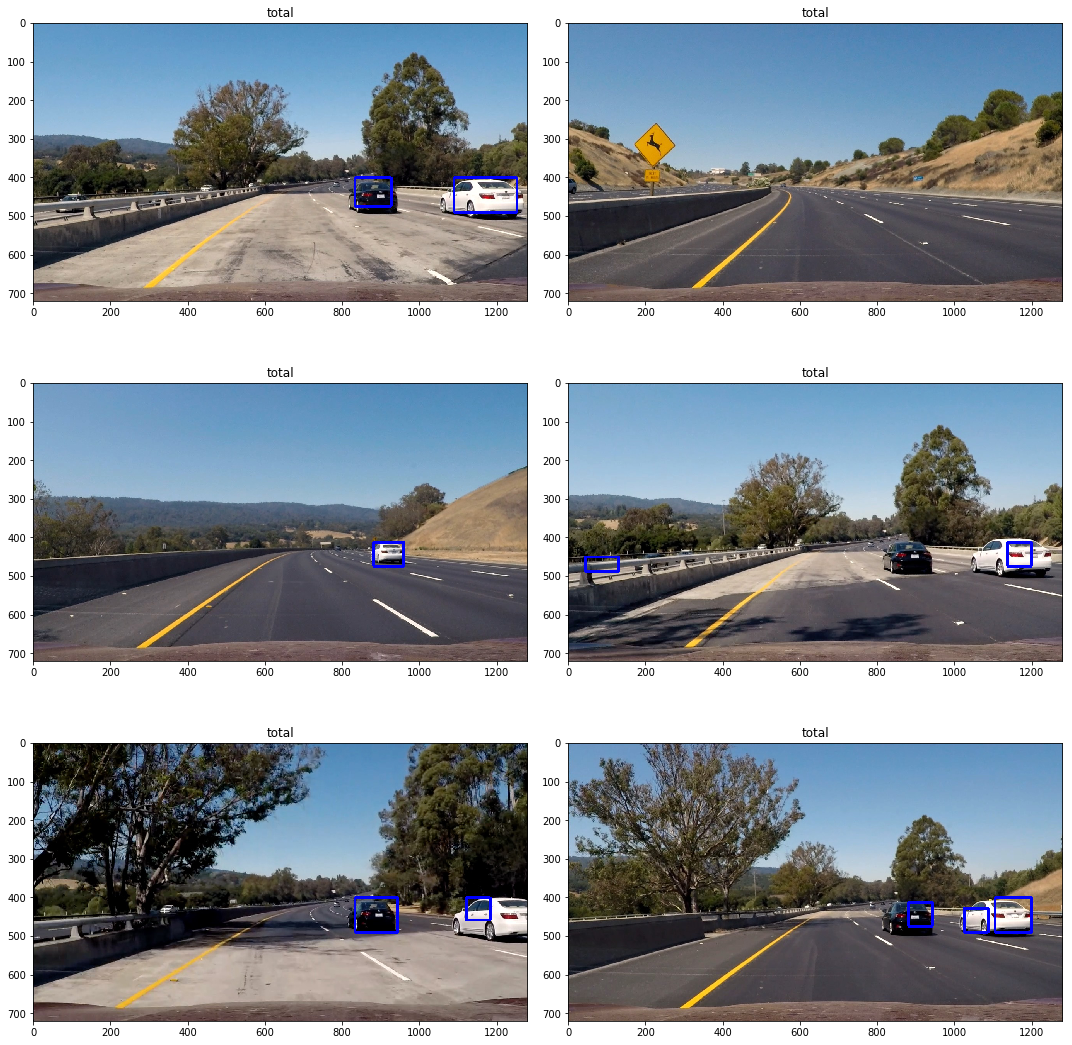

In [268]:

    
test_images = glob.glob('test_images/test*.jpg')

imgs_list = []
titles_list = []
heats = collections.deque(maxlen=1)
heats1 = collections.deque(maxlen=1)
heats2 = collections.deque(maxlen=1)
heats3 = collections.deque(maxlen=1)
for test_img in test_images:
    # for png read from matplotlib
    #img = np.uint8(plt.imread(test_img)*255)
    # for jpg
    img = plt.imread(test_img)

    bbox_list1, out_img1 = find_cars(img, 380, 550, 1.0, svc, X_scaler, 
                            colorspace, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size=(spatial, spatial), hist_bins=histbin)

    bbox_list1, draw_img = threshold_on_heat(img, heats1, 0, bbox_list1, visualize=True)
    #imgs_list.extend((out_img1, draw_img))
    #titles_list.extend((test_img.split('/')[-1], 'thresh1'))

# 1.6 400-500.. 380, 680 1.8
    bbox_list2, out_img2 = find_cars(img, 400, 650, 1.4, svc, X_scaler, 
                            colorspace, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size=(spatial, spatial), hist_bins=histbin)

    bbox_list2, draw_img = threshold_on_heat(img, heats2, 0, bbox_list2, visualize=True)
    #imgs_list.extend((out_img2, draw_img))
    #titles_list.extend((test_img.split('/')[-1], 'thresh2'))
    
    bbox_list3, out_img3 = find_cars(img, 450, 680, 2.5, svc, X_scaler, 
                            colorspace, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size=(spatial, spatial), hist_bins=histbin)
        
    
    bbox_list3, draw_img = threshold_on_heat(img, heats3, 0, bbox_list3, visualize=True)
    #imgs_list.extend((out_img3, draw_img))
    #titles_list.extend((test_img.split('/')[-1], 'thresh3'))

    bbox_list1 = np.array(bbox_list1, np.int32).reshape(-1,2,2)
    bbox_list2 = np.array(bbox_list2, np.int32).reshape(-1,2,2)
    bbox_list3 = np.array(bbox_list3, np.int32).reshape(-1,2,2)
    bbox_list = np.vstack((bbox_list1, bbox_list2, bbox_list3))
    _, draw_img = threshold_on_heat(img, heats, 1, bbox_list, visualize=True)

    
    #for bbox in bbox_list:
    #    if len(bbox) != 0:
    #        cv2.rectangle(img, (bbox[0][0], bbox[0][1]),
    #                          (bbox[1][0], bbox[1][1]), (0,0,255), 6)
    
    imgs_list.append(draw_img)
    titles_list.append('total')
"""    
    bbox_list1 = np.array(bbox_list1, np.int32).reshape(-1,2,2)
    bbox_list2 = np.array(bbox_list2, np.int32).reshape(-1,2,2)
    ##bbox_list3 = np.array(bbox_list3, np.int32).reshape(-1,2,2)
    bbox_list = np.vstack((bbox_list1, bbox_list2))#, bbox_list3))
    
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heats.append(heat)
    heats_sum = sum(heats)
    heats_sum = apply_threshold(heats_sum, 2)
    
    heatmap = np.clip(heats_sum, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    imgs_list.append((draw_img))
    titles_list.append((test_img.split('/')[-1])+'_total')
"""    
    
    #bbox_list3, out_img3 = find_cars(img, 400, 650, 2, svc, X_scaler, orient, 
    #                        pix_per_cell, cell_per_block, hog_channel,
    #                        spatial_size=(spatial, spatial), hist_bins=histbin)
    
    #draw_img = threshold_on_bbox(img, 1, bbox_list3)
    #imgs_list.extend((out_img3, draw_img))
    #titles_list.extend((test_img.split('/')[-1], 'thresh3'))

    

    #draw_img = threshold_on_bbox(img, 1, bbox_list)
    
    #imgs_list.append((draw_img))
    #titles_list.append((test_img.split('/')[-1])+'_total')
    

plot_images(imgs_list, titles_list)

## 6. Pipelining Video

In [271]:
heats = collections.deque(maxlen=5)
heats1 = collections.deque(maxlen=5)
heats2 = collections.deque(maxlen=5)
heats3 = collections.deque(maxlen=5)

def process_image(img):
    # The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image where lines are drawn on lanes)

    bbox_list1, out_img = find_cars(img, 380, 550, 1.0, svc, X_scaler, 
                            colorspace, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size=(spatial, spatial), hist_bins=histbin)
    
    bbox_list2, draw_img = find_cars(img, 400, 650, 1.4, svc, X_scaler, 
                            colorspace, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size=(spatial, spatial), hist_bins=histbin)

    bbox_list3, out_img = find_cars(img, 450, 680, 2.5, svc, X_scaler, 
                            colorspace, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size=(spatial, spatial), hist_bins=histbin)

    
    #bbox_list1 = threshold_on_heat(img, heats1, 7, bbox_list1) 
    #bbox_list2 = threshold_on_heat(img, heats2, 5, bbox_list2)
    #bbox_list3 = threshold_on_heat(img, heats3, 3, bbox_list3)

    bbox_list1 = np.array(bbox_list1, np.int32).reshape(-1,2,2)
    bbox_list2 = np.array(bbox_list2, np.int32).reshape(-1,2,2)
    bbox_list3 = np.array(bbox_list3, np.int32).reshape(-1,2,2)
    bbox_list = np.vstack((bbox_list1, bbox_list2, bbox_list3))
    bbox_list, draw_img = threshold_on_heat(img, heats, 7, bbox_list, visualize=True)

    
    #heat = np.zeros_like(img[:,:,0]).astype(np.float)
    #heat = add_heat(heat, bbox_list)
    #heats.append(heat)
    #heats_sum = sum(heats)
    #heats_sum = apply_threshold(heats_sum, 4)
    
    #heatmap = np.clip(heats_sum, 0, 255)
    #labels = label(heatmap)
    #bb, draw_img = draw_labeled_bboxes(labels, np.copy(img))
    
    

    #out = cv2.addWeighted(image, 1, unwarped, 0.6, 0)

    return draw_img

    
project_output = 'project_output.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [19:27<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 18min 32s, sys: 1min 5s, total: 19min 38s
Wall time: 19min 28s


In [272]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(project_output))

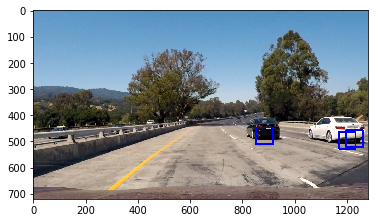

In [124]:

templist = ['./vehicles/GTI_Far/image0000.png', './vehicles/GTI_Far/image0001.png', 
            './vehicles/GTI_Far/image0002.png']

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    # Make a copy of the image to draw on
    # Define an empty list to take bbox coords
    bbox_list = []
    # Iterate through template list
    for template in template_list:
    # Read in templates one by one
        template_img = cv2.imread(template)
        h = template_img.shape[0]
        w = template_img.shape[1]
    # Use cv2.matchTemplate() to search the image
    #     using whichever of the OpenCV search methods you prefer
        result = cv2.matchTemplate(img, template_img, cv2.TM_CCOEFF)
    # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    # Determine bounding box corners for the match
        bbox_list.append([(max_loc), (max_loc[0]+w, max_loc[1]+h)])
    # Return the list of bounding boxes
    return bbox_list

bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

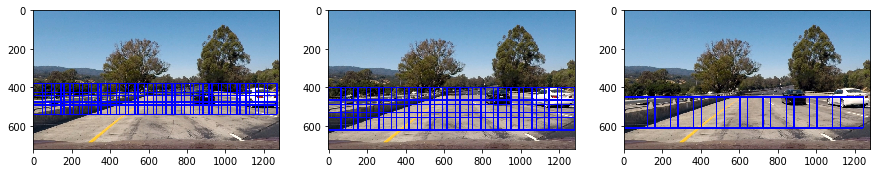

In [270]:

# takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None: x_start_stop[0] = 0
    if x_start_stop[1] == None: x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None: y_start_stop[0] = 0
    if y_start_stop[1] == None: y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    s_x = x_start_stop[1] - x_start_stop[0]
    s_y = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    stride_x = np.int(xy_window[0] * xy_overlap[0])
    stride_y = np.int(xy_window[1] * xy_overlap[1])
    # Compute the number of windows in x/y
    nw_x = np.int((s_x - xy_window[0]) / stride_x) + 1
    nw_y = np.int((s_y - xy_window[1]) / stride_y) + 1
    
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for nw_yy in range(nw_y):
        starty = nw_yy*stride_y + y_start_stop[0]
        endy = starty + xy_window[1]
        for nw_xx in range(nw_x):
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
            startx = nw_xx*stride_x
            endx = startx + xy_window[0]
            window_list.append(((startx, starty), (endx, endy)))
        # Append window position to list
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 550], 
                    xy_window=(int(64*1.0), int(64*1.0)), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(window_img)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 650], 
                    xy_window=(int(64*1.4), int(64*1.4)), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
axes[1].imshow(window_img)


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[450, 680], 
                    xy_window=(int(64*2.5), int(64*2.5)), xy_overlap=(0.75, 0.75))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
axes[2].imshow(window_img)


In [ ]:
# test code

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# pass an image and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    